In [1]:
import math
import numpy as np
import pandas as pd
from numpy import arange
from matplotlib import pyplot
from pandas import read_csv
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

#from sklearn.externals.joblib import dump
#from sklearn.externals.joblib import load
#from sklearn.feature_selection import RFE

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

# Create one random seed number for reproducible results
seedNum = 888

# Libraries for neural network
import tensorflow
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [20]:
outlier_flag = True      # Will threshold the outliers to outlier value
outlier_max_value = 25000
scale_flag = False

In [3]:
# Display all columns in pandas
pd.set_option('display.max_columns', None)

### Reading data

In [5]:
inputFile = '../data/output/OnlineNewsPopularity_featureEngg.csv' #Kannan stiched this file
df = read_csv(inputFile)
df.columns = df.columns.str.replace(' ','')
print(df.shape)
df.head()

(7795, 42)


,keywords_pca_3,NER_DATE,num_imgs,n_tokens_title,data_channel_is_entertainment,data_channel_is_socmed,NER_list_pca_2,keywords_pca_4,keywords_pca_6,average_token_length,n_non_stop_words,data_channel_is_lifestyle,data_channel_is_bus,is__Monday,NER_PERCENT,is__Tuesday,NER_list_pca_4,num_hrefs,n_unique_tokens,is__Friday,NER_list_pca_9,NER_list_pca_0,subjectivity_content,keywords_pca_1,keywords_pca_2,n_non_stop_unique_tokens,num_keywords,keywords_pca_7,is__Saturday,data_channel_is_tech,data_channel_is_world,NER_list_pca_1,num_videos,NER_ORDINAL,is__Thursday,keywords_pca_9,is_Weekend,is__Wednesday,NER_LANGUAGE,Id,shares,url
0,0.824494,16,1,10,0,0,2.477704,0.587261,0.445485,4.873563,1.0,0,0,1,0,0,-3.714906,7,0.661355,0,-0.109758,57.171860,0.390972,1.098373,-0.216242,0.787500,7,0.087398,0,0,1,14.415299,1,0,0,-0.052964,0,0,0,1,1100,http://mashable.com/2014/09/01/americans-held-...
1,1.642639,3,50,7,0,0,-1.085392,-0.390698,-0.310026,4.554439,1.0,0,0,1,0,0,-0.918664,74,0.370242,0,0.106860,14.814661,0.618573,-1.679171,-1.123091,0.535038,8,-0.153742,0,0,0,0.430153,0,0,0,0.278347,0,0,0,2,1100,http://mashable.com/2014/09/01/apple-visa-mast...
2,-0.439429,11,1,7,0,0,5.071529,-0.441275,0.401293,5.003976,1.0,0,0,1,0,0,-1.831361,3,0.524291,0,0.418020,66.078323,0.348095,1.891317,-0.792684,0.704918,5,0.385288,0,0,1,20.685003,0,1,0,0.520324,0,0,0,3,1000,http://mashable.com/2014/09/01/aussie-football...
3,0.145078,2,1,10,0,0,-3.481954,0.423683,0.819319,4.998099,1.0,0,0,1,0,0,-5.091683,17,0.536204,0,-1.181669,23.704344,0.378684,-1.054871,-1.104305,0.654867,9,-0.613054,0,0,1,-0.189292,0,2,0,0.097977,0,0,0,4,822,http://mashable.com/2014/09/01/australia-gover...
4,0.639700,6,1,13,0,0,-10.271313,-0.420657,-0.600039,5.046414,1.0,0,0,1,0,0,-0.021364,5,0.619048,0,0.440254,47.331295,0.486269,-0.588262,0.955642,0.807143,9,0.889573,0,0,1,-7.977846,0,1,0,-0.662537,0,0,0,5,841,http://mashable.com/2014/09/01/australia-jane-...


In [6]:
# Dropping useless attributes
df.drop('url', axis=1, inplace=True)
df.drop('Id', axis=1, inplace=True)

In [7]:
# variables for total columns, total input attributes, target column index and renaming target variable
totCol = len(df.columns)
totAttr = totCol-1
targetCol = totCol #last column
df.rename(columns={'shares': 'targetVar'}, inplace=True)

In [8]:
# Threshold the value > outlier_max_value to value outlier_max_value itself in column shares or targetVar
print(df[(df['targetVar'] == outlier_max_value)].shape)
print(df[(df['targetVar'] > outlier_max_value)].shape)
df['targetVar'] = df['targetVar'].clip(upper = outlier_max_value)
print(df[(df['targetVar'] == outlier_max_value)].shape)

(2, 40)
(106, 40)
(108, 40)


In [9]:
df.shape

(7795, 40)

In [10]:
#70:30 train test split
if targetCol == totCol :
    x_df = df.iloc[:,0:totAttr]
    y_df = df.iloc[:,totAttr]
else :
    x_df = df.iloc[:,1:totCol]
    y_df = df.iloc[:,0]

validation_size = 0.30
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=validation_size, random_state=seedNum)
print("x_df.shape: {} y_df.shape: {}".format(x_df.shape, y_df.shape))
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))

x_df.shape: (7795, 39) y_df.shape: (7795,)
x_train.shape: (5456, 39) y_train.shape: (5456,)
x_test.shape: (2339, 39) y_test.shape: (2339,)


In [11]:
# visualization configs
dispCol = 3
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to 16 and height to 12 (4:3 aspect ratio)
fig_size = pyplot.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
pyplot.rcParams["figure.figsize"] = fig_size

In [12]:
#kannan: This is decided from feature engineering / feature selection
lowAttributes=[]

In [13]:
# Removing the unselected attributes from the training and validation dataframes
#xy_train <- xy_train[, !(names(xy_train) %in% lowAttributes)]
#xy_test <- xy_test[, !(names(xy_test) %in% lowAttributes)]
xy_newdf = df.drop(lowAttributes, axis=1)

totCol = len(xy_newdf.columns)
totAttr = totCol-1
targetCol = totCol
array = xy_newdf.values

if targetCol == totCol :
    x_newdf = array[:,0:totAttr]
    y_newdf = array[:,totAttr]
else :
    x_newdf = array[:,1:totCol]
    y_newdf = array[:,0]

validation_size = 0.30
x_train, x_test, y_train, y_test = train_test_split(x_newdf, y_newdf, test_size=validation_size, random_state=seedNum)
print("x_newdf.shape: {} y_newdf.shape: {}".format(x_newdf.shape, y_newdf.shape))
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))

x_newdf.shape: (7795, 39) y_newdf.shape: (7795,)
x_train.shape: (5456, 39) y_train.shape: (5456,)
x_test.shape: (2339, 39) y_test.shape: (2339,)


## Traditional ML Models Evaluation

In [14]:
# Comparing various types of regression # K-fold cross validation
num_folds = 10
scoring = 'neg_mean_squared_error'
#Other scoring options: https://scikit-learn.org/stable/modules/model_evaluation.html
models = []

# LINEAR ALGORITHMS
# -----------------
# Linear Regression
models.append(('LR', LinearRegression()))
# Ridge Regression
models.append(('RR', Ridge(random_state=seedNum)))
# Lasso Regression
models.append(('LASSO', Lasso(random_state=seedNum)))
# Elastic Net
models.append(('EN', ElasticNet(random_state=seedNum)))

# NON-LINEAR ALGORITHMS
# ---------------------
# Classification and Regression Trees
models.append(('CART', DecisionTreeRegressor(random_state=seedNum)))
# K Nearest Neighbor
models.append(('KNN', KNeighborsRegressor()))
# Suppor Vector machine
models.append(('SVM', SVR()))

# ENSEMBLE ALGORITHMS
# -------------------
# Extra Trees
models.append(('ETree', ExtraTreesRegressor(random_state=seedNum)))
# Random Forest
models.append(('RF', RandomForestRegressor(random_state=seedNum)))
# Stochastic Gradient Boosting
models.append(('GBM', GradientBoostingRegressor(random_state=seedNum)))
# Adaptive Boosting
models.append(('ABM', AdaBoostRegressor(random_state=seedNum)))

results = []
names = []
metrics1= [] #RMSE_Training
metrics2= [] #RMSE_Testing

## Adding DL Model

In [15]:
def baseline_model(init_mode='uniform', neurons=5, learn_rate=0.001, momentum=0.2, act_function='relu'):
        
    model = Sequential()
    
    model.add(BatchNormalization())
    model.add(Dense(neurons, input_dim=17, kernel_initializer=init_mode, activation=act_function))
    model.add(Dense(6,  kernel_initializer=init_mode, activation=act_function))
    model.add(Dense(1,  kernel_initializer=init_mode))
    
    optimizer = tensorflow.keras.optimizers.RMSprop(lr=learn_rate, momentum=momentum)
    model.compile(loss='mean_squared_error', optimizer=optimizer, )
    
    return model

estimator = KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=10, verbose=0)

In [16]:
models.append(('DL', estimator))

## Training

In [17]:
for name, model in models:
    startTimeModule = datetime.now()
    kfold = KFold(n_splits=num_folds, random_state=seedNum)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    rmse=math.sqrt(abs(cv_results.mean()))
    metrics1.append(rmse)
    print("\n%s: rmse:%f" % (name, rmse))
    print ('Model training time:',(datetime.now() - startTimeModule))


LR: rmse:3801.374058
Model training time: 0:00:00.957764

RR: rmse:3801.123554
Model training time: 0:00:00.238356

LASSO: rmse:3800.762350
Model training time: 0:00:00.934719

EN: rmse:3842.332007
Model training time: 0:00:00.219154

CART: rmse:5647.327816
Model training time: 0:00:04.507837

KNN: rmse:4179.558000
Model training time: 0:00:02.511772

SVM: rmse:4108.045447
Model training time: 0:00:47.405815

ETree: rmse:3921.401042
Model training time: 0:01:39.382282

RF: rmse:3963.415939
Model training time: 0:04:29.912884

GBM: rmse:3885.614407
Model training time: 0:01:09.855943

ABM: rmse:4963.035611
Model training time: 0:00:10.153227
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

DL: rmse:3813.414165
Model training time: 0:09:37.225331


## Testing

In [21]:
for name, model in models:
    model.fit(x_train, y_train)
    predictions=model.predict(x_test)
    rmse=math.sqrt(mean_squared_error(y_test, predictions))
    metrics2.append(rmse)
    print("\n%s: rmse:%f" % (name, rmse))


LR: rmse:4028.980094

RR: rmse:4029.083752

LASSO: rmse:4029.237458

EN: rmse:4076.998110

CART: rmse:6023.365570

KNN: rmse:4426.581822

SVM: rmse:4352.261760

ETree: rmse:4180.518933

RF: rmse:4157.029195

GBM: rmse:4118.292152

ABM: rmse:4702.501249

DL: rmse:4027.734646


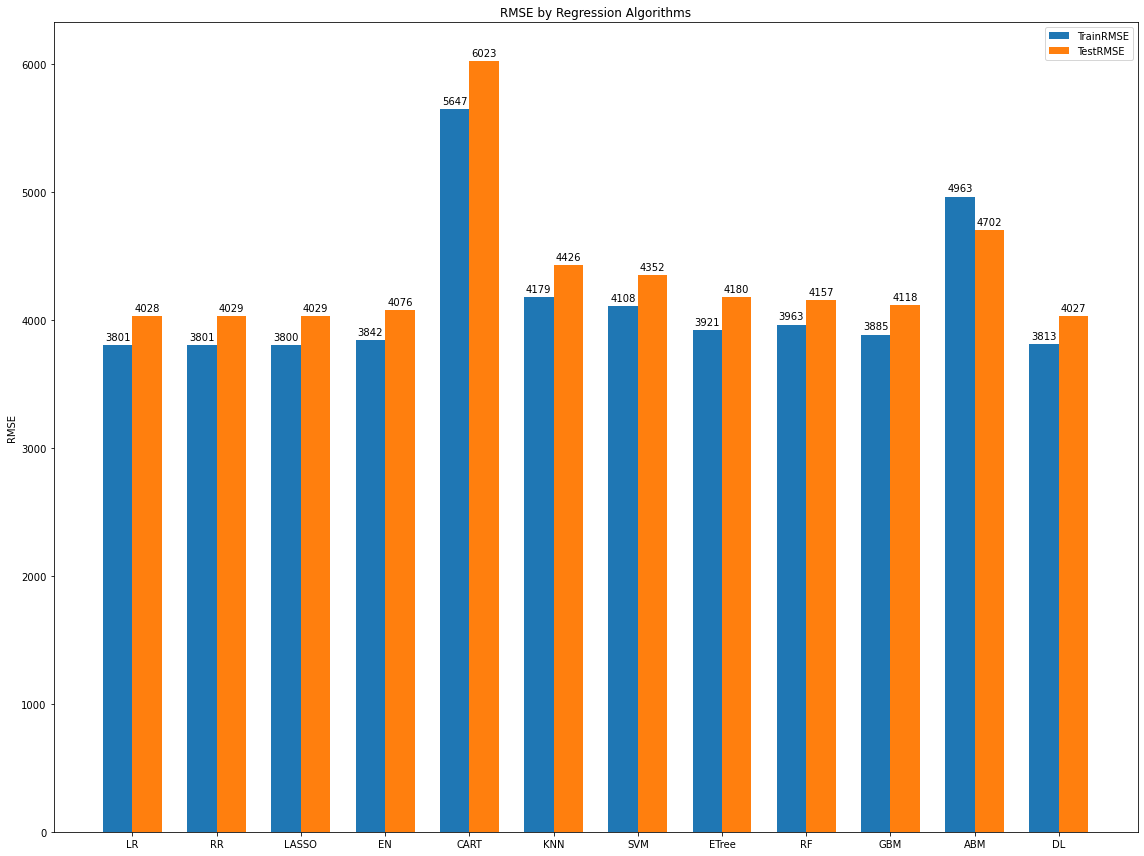

In [22]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = names

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

metrics1=[math.floor(item) for item in metrics1]
metrics2=[math.floor(item) for item in metrics2]

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, metrics1, width, label='TrainRMSE')
rects2 = ax.bar(x + width/2, metrics2, width, label='TestRMSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('RMSE by Regression Algorithms')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()